In [1]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd

font_manager       INFO 	generated new fontManager


In [2]:
# Enable the cache
ff1.Cache.enable_cache('/cache') 

# Setup plotting
plotting.setup_mpl()

NotADirectoryError: Cache directory does not exist! Please check for typos or create it first.

In [3]:
# Enable the cache
ff1.Cache.enable_cache('cache') 

# Setup plotting
plotting.setup_mpl()

In [27]:
# Load the session data
quali = ff1.get_session(2021, 'Abu Dhabi', 'R')

# Get the laps
laps = quali.load_laps(with_telemetry=True)

core           INFO 	Loading laps for Abu Dhabi Grand Prix - Race [v2.1.12]
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for session_status_data. Loading data...
api            INFO 	Fetching session status data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for track_status_data. Loading data...
api            INFO 	Fetching track 

In [28]:
# Select the laps from Hamilton and Verstappen
laps_ver = laps.pick_driver('VER')
laps_ham = laps.pick_driver('HAM')

# Get the telemetry data from their fastest lap
fastest_ver = laps_ver.pick_fastest().get_telemetry().add_distance()
fastest_ham = laps_ham.pick_fastest().get_telemetry().add_distance()

# Since the telemetry data does not have a variable that indicates the driver, 
# we need to create that column
fastest_ver['Driver'] = 'VER'
fastest_ham['Driver'] = 'HAM'

# Merge both lap telemetries so we have everything in one DataFrame
telemetry = fastest_ver.append(fastest_ham)


In [29]:
# We want 25 mini-sectors (this can be adjusted up and down)
num_minisectors = 25

# Grab the maximum value of distance that is known in the telemetry
total_distance = total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

In [30]:
# Initiate minisector variable, with 0 (meters) as a starting point.
minisectors = [0]

# Add multiples of minisector_length to the minisectors
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

In [31]:
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

In [32]:
# Calculate avg. speed per driver per mini sector
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

In [33]:
# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

In [34]:
# Join the fastest driver per minisector with the full telemetry
telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == 'VER', 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == 'HAM', 'Fastest_driver_int'] = 2

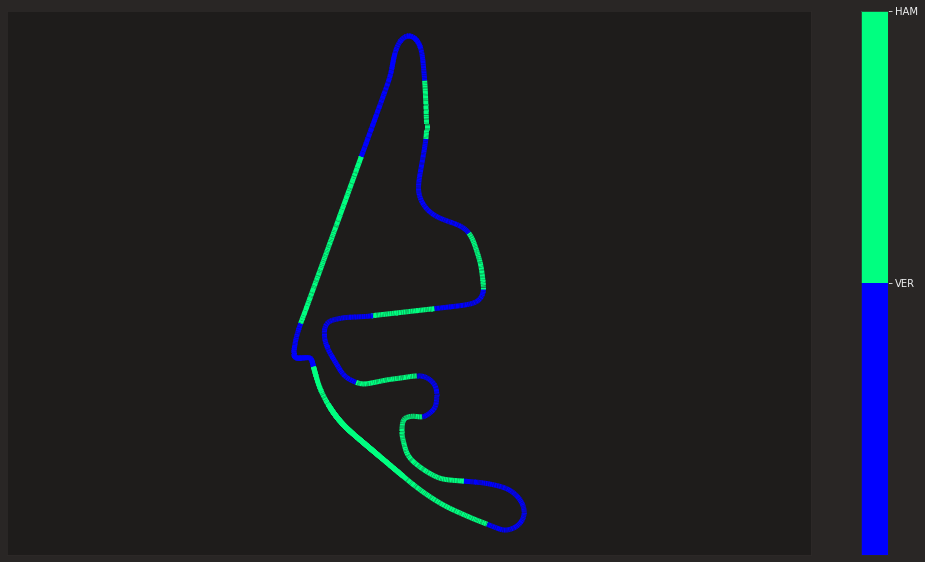

In [36]:
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

cmap = cm.get_cmap('winter', 2)
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(5)

plt.rcParams['figure.figsize'] = [18, 10]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,4))
cbar.set_ticks(np.arange(2, 4))
cbar.set_ticklabels(["VER", "HAM"])

plt.savefig(f"2021_ver_ham_q.png", dpi=300)

plt.show()